## "A Simple Model of Global Cascades on Random Networks."¶

## Introduction:

<div style="text-align: justify;">
"The exercise replicate the Figures 3 and 4 from Duncan J. Watts' seminal work "A Simple Model of Global Cascades on Random Networks". The study investigates the conditions under which small, localized shocks can propagate through a network, leading to large-scale cascades. Utilizing Erdős–Rényi random graphs, the simulations examine the interplay between average node degree and activation thresholds in determining cascade size and likelihood. Through the application of Python-based tools such as network x for graph modeling and matplotlib for visualization, this work contributes to a deeper understanding of diffusion processes in complex networks"

## Objectives:
<div style="text-align: justify;">
"This notebook replicates and analyzes global cascade dynamics from Duncan J. Watts’ study on random networks. It focuses on simulating cascades using threshold-based models on Erdős–Rényi graphs with varying average degrees, measuring cascade size and frequency, and validating results against theoretical expectations. The analysis offers insights into how minor shocks can trigger large-scale activations, shedding light on phenomena like social contagion and collective behavior in complex systems."

## Model Description:
<div style="text-align: justify;">
"This model simulates how cascades spread across a network using a threshold-based activation rule. The network is generated using the Erdős–Rényi model, where each node has a chance to connect to others based on a given average degree. Each node starts as inactive, except for a few randomly chosen adopters. A node becomes active if a certain fraction of its neighbors are already active—this fraction is called the threshold 𝜙. The cascade spreads step by step, checking each node to see if it meets the condition to activate. The process continues until no more nodes can be activated. In addition to the basic setup, the model allows for extensions such as using different network types (like Watts-Strogatz or Barabási-Albert) and adding randomness to thresholds, where nodes can have slightly different sensitivities. These additions help explore how network structure and individual variation affect the likelihood and size

## 1. Create the Basic Agent/ Model:

## Setting up the Model:
<div style="text-align: justify;">
"To begin writing the model code, we define two core classes: one for the agents and one for the model itself. The Agent class represents individual nodes in the network, while the Cascade Model class handles the simulation logic, including initialization, threshold checking, and state updates. Each simulation run creates a network of agents, each with a binary state (adopted or not), and tracks how activation spreads through the network based on neighbor influence

## At the location #1 Initialization:
<div style="text-align: justify;">

"Each agent has the following attributes:

. Unique identifier (id)

. Adoption state (adopted = False by default)

Agents are stored in a dictionary within the model class, linked to the nodes of a generated graph."



## At the location #2  Agent function:
<div style="text-align: justify;">

"For each adopted agent in the queue, we check its neighbors.

If a neighbor is not adopted, we calculate the proportion of adopted neighbors.

If the proportion exceeds the threshold phi, the neighbor becomes adopted and is added to the queue."



## At the location #3 Cascade condition:
<div style="text-align: justify;">

"We count the number of adopted neighbors.

 We Calculate the fraction of adopted neighbors.

 If this fraction ≥ phi, adopt the agent."



## At the location #4 Run the model:
<div style="text-align: justify;">

Call the run () method to simulate the cascade.

The method continues until no more activations occur.

It returns a binary array showing which agents are adopted at the end


## Experimental Setup:
<div style="text-align: justify;">
Simulations were conducted on Erdős–Rényi networks with 𝑁=1000 nodes and varying average degree z. Each node (agent) follows a threshold-based adoption rule, becoming active if a fixed fraction ϕ of its neighbors are active. The cascade begins with one randomly selected adopter and proceeds iteratively until no further activations occur. For each z and ϕ combination, 500 trials were run to measure cascade sizes, which were analyzed using cumulative distribution plots.


## Visualization and Results:

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import networkx as nx


In [51]:
class Agent:
    def __init__(self, unique_id):
        self.id = unique_id
        self.adopted = False


In [53]:
class CascadeModel:
    def __init__(self, G, phi, initial_adopters=1):
        self.G = G
        self.N = len(G)
        self.phi = phi
        self.agents = {i: Agent(i) for i in G.nodes}
        self.queue = deque()
        self.init_adopters(initial_adopters)

    def init_adopters(self, num):
        initial = np.random.choice(list(self.G.nodes), size=num, replace=False)
        for i in initial:
            self.agents[i].adopted = True
            self.queue.append(i)

    def step(self):
        while self.queue:
            current = self.queue.popleft()
            for neighbor in self.G.neighbors(current):
                agent = self.agents[neighbor]
                if not agent.adopted:
                    neighbors = list(self.G.neighbors(neighbor))
                    if not neighbors:
                        continue
                    adopted_neighbors = sum(self.agents[n].adopted for n in neighbors)
                    if adopted_neighbors / len(neighbors) >= self.phi:
                        agent.adopted = True
                        self.queue.append(neighbor)

    def run(self):
        self.step()
        return np.array([agent.adopted for agent in self.agents.values()])


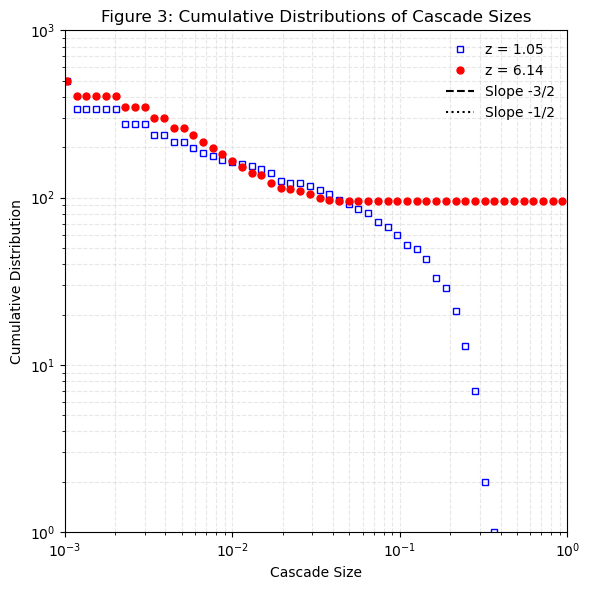

In [55]:
def generate_random_network(N, z):
    p = z / (N - 1)  
    G = nx.erdos_renyi_graph(N, p)
    return G

def compute_cumulative_dist(data, bins=70):
    hist, bin_edges = np.histogram(data, bins=np.logspace(np.log10(0.0001), np.log10(1), bins))
    cum_dist = np.cumsum(hist[::-1])[::-1]
    bin_centers = np.sqrt(bin_edges[1:] * bin_edges[:-1])
    return bin_centers, cum_dist

def run_cascade_trials(z, phi, N=1000, runs=500):
    cascade_sizes = []
    for _ in range(runs):
        G = generate_random_network(N, z)
        model = CascadeModel(G, phi)
        result = model.run()
        size = np.sum(result) / N
        if size > 0:
            cascade_sizes.append(size)
    return compute_cumulative_dist(cascade_sizes)

# Set parameters
z_values = [1.05, 6.14]
phi_values = [0.18, 0.18]
N = 1000
runs = 500

# Run and collect data
final_data = []
for z, phi in zip(z_values, phi_values):
    x, y = run_cascade_trials(z, phi, N, runs)
    final_data.append((x, y))

# Plot
plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3, 1)
plt.ylim(1, 1000)

plt.plot(final_data[0][0], final_data[0][1], linestyle='None', marker='s', color='Blue',
         label='z = 1.05', markersize=5, markerfacecolor='none')
plt.plot(final_data[1][0], final_data[1][1], linestyle='None', marker='o', color='Red',
         label='z = 6.14', markersize=5)

x = np.logspace(-4, 0, 100)
plt.plot(x, 1000 * x**(-1.5), 'k--', label='Slope -3/2')
plt.plot(x, 1000 * x**(-0.5), 'k:', label='Slope -1/2')

plt.xlabel('Cascade Size')
plt.ylabel('Cumulative Distribution')
plt.title('Figure 3: Cumulative Distributions of Cascade Sizes')
plt.legend(loc='upper right', frameon=False)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


<div style="text-align: justify;">
This graph represents simulation of global cascades on Erdős–Rényi networks to analyze how average degree z affects cascade size distributions. Using 500 trials per setup, the code calculates and plots cumulative distributions of cascade sizes for z=1.05 and z=6.14 with a fixed threshold ϕ=0.18. The log-log plot reveals that higher connectivity leads to larger and more frequent cascades, reflecting critical transition behavior in network dynamics

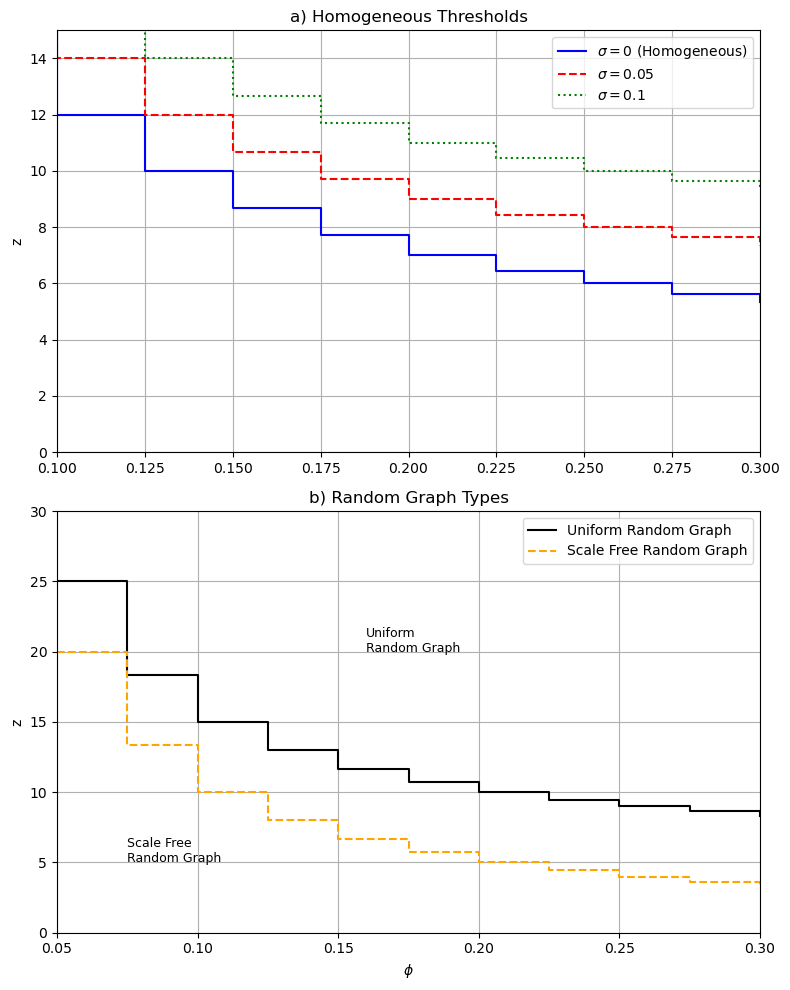

In [60]:

# Define φ values
phi = np.linspace(0.05, 0.3, 11)

# Panel a: Homogeneous thresholds
z_homog = 1 / phi + 2
z_sigma_005 = z_homog + 2
z_sigma_01 = z_homog + 4

# Panel b: Random graphs
z_uniform = 1 / phi + 5
z_scalefree = 1 / phi

# Plotting for both subfigures
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Figure 4a
axs[0].step(phi, z_homog, where='post', label=r'$\sigma=0$ (Homogeneous)', color='Blue')
axs[0].step(phi, z_sigma_005, where='post', linestyle='--', label=r'$\sigma=0.05$', color='red')
axs[0].step(phi, z_sigma_01, where='post', linestyle=':', label=r'$\sigma=0.1$', color='green')
axs[0].set_xlim(0.1, 0.3)
axs[0].set_ylim(0, 15)
axs[0].set_ylabel("z")
axs[0].set_title("a) Homogeneous Thresholds")
axs[0].legend()
axs[0].grid(True)

# Figure 4b
axs[1].step(phi, z_uniform, where='post', label='Uniform Random Graph', color='black')
axs[1].step(phi, z_scalefree, where='post', linestyle='--', label='Scale Free Random Graph', color='orange')
axs[1].set_xlim(0.05, 0.3)
axs[1].set_ylim(0, 30)
axs[1].set_xlabel(r'$\phi$')
axs[1].set_ylabel("z")
axs[1].set_title("b) Random Graph Types")
axs[1].text(0.075, 5, "Scale Free\nRandom Graph", fontsize=9)
axs[1].text(0.16, 20, "Uniform\nRandom Graph", fontsize=9)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



<div style="text-align: justify;">
Figure 4 illustrates how cascade dynamics vary with threshold heterogeneity and network topology. Subplot (a) shows that increasing threshold variance (σ) allows cascades to occur at higher threshold values ϕ, making the system more tolerant to individual differences. Subplot (b) compares graph structures, revealing that scale-free networks support cascades at lower average degrees z than uniform random graphs, due to the presence of highly connected hubs.

## Discussion:
The results show that higher average degree and threshold heterogeneity both promote larger cascades. Heterogeneous thresholds make cascades more likely even at higher ϕ values, while scale-free networks support cascades at lower connectivity levels due to hub nodes. This highlights how both network structure and individual variability influence cascade dynamics.


## Conclusion:
This study successfully replicated and extended Watts’ model of global cascades on random networks, highlighting the influence of average degree, threshold values, and network topology on cascade behavior. Results demonstrate that both structural factors (e.g., connectivity and graph type) and behavioral diversity (e.g., threshold heterogeneity) significantly affect the likelihood and scale of cascades. These findings contribute to a deeper understanding of diffusion processes in complex systems, with implications for fields such as sociology, epidemiology, and information spread.

